# Data Analyssis With Airbnb Open Dataset

In [122]:
#Import Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
from api_keys import gkey
import requests
from scipy.stats import linregress
gmaps.configure(api_key=gkey)

## Transform the dataset to hold only relevant information

In [123]:
#Import Data From CSV.file And Drop Unwanted Columns

df=pd.read_csv('InputData/listings.csv')
df=df.drop(['neighbourhood_group','license','number_of_reviews_ltm','calculated_host_listings_count',
                'host_name','name','host_id','reviews_per_month'],axis=1)

# Set Perth Metropolitan Area And Days For Travel Purposes 

targeted_df=df.loc[(df['latitude']>= -32.5468)&
                      (df['latitude'] <= -31.7725)&
                      (df['longitude'] <= 116.0593)&
                      (df['minimum_nights']<=15)]


#Based On Latitude,Sorting Value From North To South

sortedNorthToSouth_df=targeted_df.dropna(how='any').sort_values('latitude',ascending=False)

#Adjust The Data

sortedNorthToSouth_df['Occupancy']=365-sortedNorthToSouth_df['availability_365']

#Focus on Two types of room_type:Entire home/apt & Private room'

narrowed_df=sortedNorthToSouth_df[(sortedNorthToSouth_df['room_type']=='Entire home/apt')|((sortedNorthToSouth_df['room_type']=='Private room'))]

# As neighbourhood of PEPPERMINT GROVE and MURRAY only records one room_type in our interset, we drop these two neighbourhoods

cleaned_df=narrowed_df.loc[~((narrowed_df['neighbourhood']=='PEPPERMINT GROVE')|(narrowed_df['neighbourhood']=='MURRAY')),:]

cleaned_df.head()

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,availability_365,Occupancy
9217,597266527035707418,JOONDALUP,-31.77258,115.74539,Entire home/apt,198,2,8,2022-06-02,343,22
5364,38862794,WANNEROO,-31.77287,115.82548,Private room,40,6,18,2022-06-12,348,17
3423,24808964,WANNEROO,-31.77314,115.87767,Entire home/apt,110,1,178,2022-06-14,330,35
3070,22778235,JOONDALUP,-31.77332,115.73488,Entire home/apt,128,2,21,2021-08-27,317,48
3710,27191991,JOONDALUP,-31.77340,115.73292,Entire home/apt,128,2,52,2022-05-20,231,134


## Which suburbs are the most popular to stay, based on the numbers of reviews? 
 

In [124]:
#List Neighbourhoods

neighbourhoods=cleaned_df[cleaned_df['room_type']=='Entire home/apt']['neighbourhood'].unique()

#Creat A New Dataframe To Analyse Our Questions.

entireHome_Apt_Price=[]
entireHome_Apt_Occup=[]
entireHome_Apt_reviews=[]

privateRoom_Price=[]
privateRoom_occup=[]
privateRoom_reviews=[]

for neighbourhood in neighbourhoods:
    entireHome_Apt_Price.append(round(cleaned_df.loc[(cleaned_df['room_type']=='Entire home/apt')&(cleaned_df['neighbourhood']==neighbourhood)]['price'].mean(),2))
    entireHome_Apt_Occup.append(round(cleaned_df.loc[(cleaned_df['room_type']=='Entire home/apt')&(cleaned_df['neighbourhood']==neighbourhood)]['Occupancy'].mean(),2))
    entireHome_Apt_reviews.append(round(cleaned_df.loc[(cleaned_df['room_type']=='Entire home/apt')&(cleaned_df['neighbourhood']==neighbourhood)]['number_of_reviews'].sum(),2))
    privateRoom_occup.append(round(cleaned_df.loc[(cleaned_df['room_type']=='Private room')&(cleaned_df['neighbourhood']==neighbourhood)]['Occupancy'].mean(),2))
    privateRoom_Price.append(round(cleaned_df.loc[(cleaned_df['room_type']=='Private room')&(cleaned_df['neighbourhood']==neighbourhood)]['price'].mean(),2))
    privateRoom_reviews.append(round(cleaned_df.loc[(cleaned_df['room_type']=='Private room')&(cleaned_df['neighbourhood']==neighbourhood)]['number_of_reviews'].sum(),2))
    
final_df=pd.DataFrame({'Neighbourhoods':neighbourhoods,
                       'EntireHome/Apt Occupancy':entireHome_Apt_Occup,
                       'EntireHome/Apt Price':entireHome_Apt_Price,
                       'EntireHome/Apt Reviews':entireHome_Apt_reviews,
                       'Private Room Occupancy':privateRoom_occup,
                       'Private Room Price':privateRoom_Price,
                       'Private Rooms Reviews':privateRoom_reviews})
                       
final_df["Total Reviews"] = final_df["EntireHome/Apt Reviews"] + final_df["Private Rooms Reviews"]

final_df.head()

,Neighbourhoods,EntireHome/Apt Occupancy,EntireHome/Apt Price,EntireHome/Apt Reviews,Private Room Occupancy,Private Room Price,Private Rooms Reviews,Total Reviews
0,JOONDALUP,221.20,186.95,5195,145.94,79.22,478,5673
1,WANNEROO,191.50,141.90,767,34.75,49.75,66,833
2,SWAN,207.84,171.22,3127,161.52,260.29,1284,4411
3,STIRLING,198.50,193.75,17164,169.93,97.12,3211,20375
4,MUNDARING,226.00,134.17,534,287.50,45.00,17,551


In [125]:
final_df.dtypes

Neighbourhoods               object
EntireHome/Apt Occupancy    float64
EntireHome/Apt Price        float64
EntireHome/Apt Reviews        int64
Private Room Occupancy      float64
Private Room Price          float64
Private Rooms Reviews         int64
Total Reviews                 int64
dtype: object

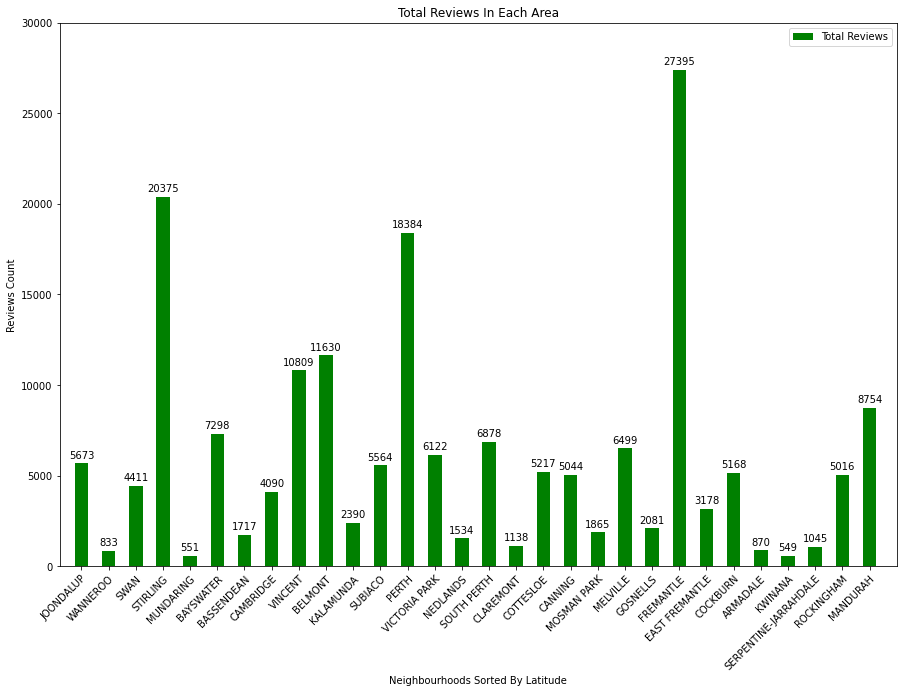

In [126]:
#Analyse The Relationship Between Neighbourhoods And Total Reviews

x_ticks=final_df['Neighbourhoods']
x_axis=np.arange(len(x_ticks))
xvalue=final_df['Total Reviews']
plt.figure(figsize=(15, 10))
plt.bar(x_axis,xvalue,facecolor='green',align='center',width=0.5)

for x,y in enumerate(final_df['Total Reviews']):
    plt.text(x,y+300,'%s'%y,ha='center')


tick_locations = [value for value in x_axis]
labels=['Total Reviews']
plt.xticks(tick_locations,x_ticks,rotation_mode='anchor', ha="right", rotation = 45)
plt.title('Total Reviews In Each Area')
plt.xlabel('Neighbourhoods Sorted By Latitude')
plt.ylabel('Reviews Count')
plt.xlim(-0.8,len(x_ticks))
plt.ylim(0,30000)
plt.legend(labels);

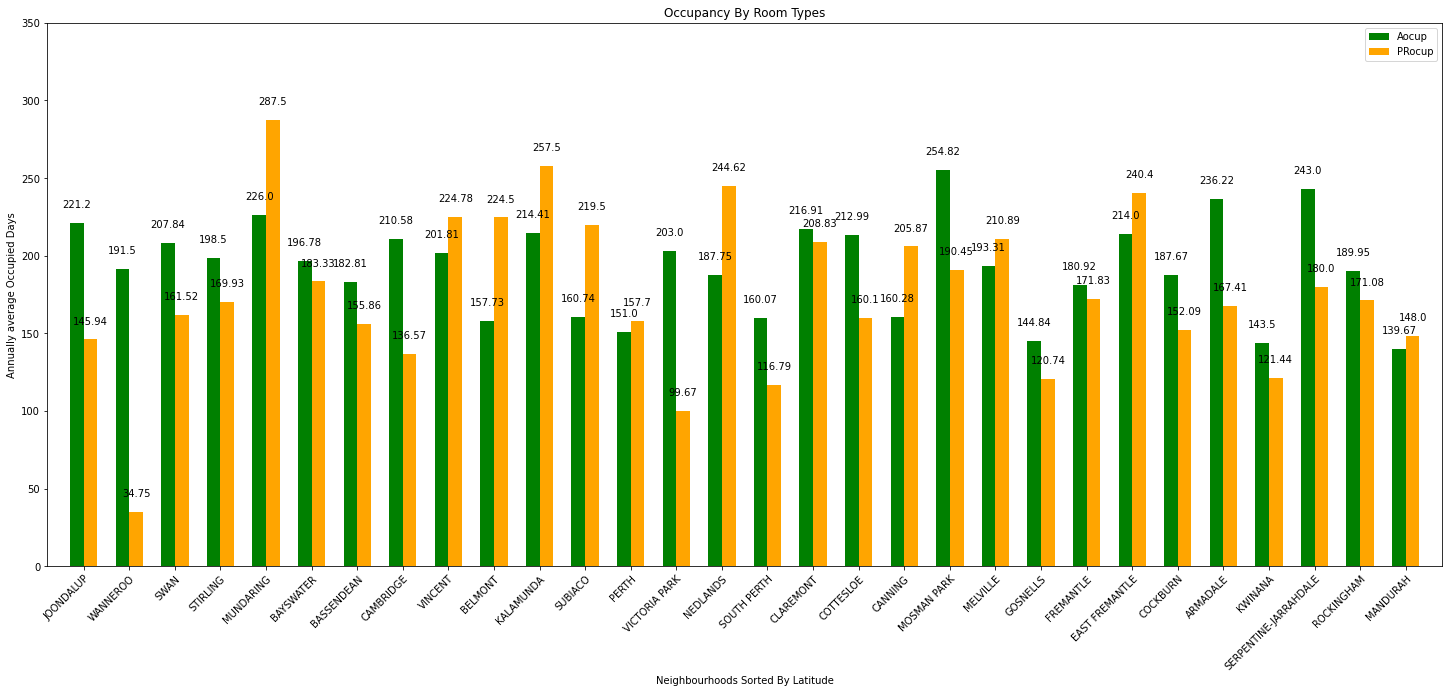

In [127]:
#Analyse The Relationship Between Neighbourhoods And Occupancy Of Two Room Types

x_ticks=final_df['Neighbourhoods']
x_axis=np.arange(len(x_ticks))
xvalue=final_df['EntireHome/Apt Occupancy']
x1value=final_df['Private Room Occupancy']
plt.figure(figsize=(25, 10))
plt.bar(x_axis-0.15,xvalue,facecolor='green',align='center',width=0.3,)
plt.bar(x_axis+0.15,x1value,facecolor='orange',align='center',width=0.3)

for x,y in enumerate(final_df['EntireHome/Apt Occupancy']):
    plt.text(x-0.15,y+10,'%s'%y,ha='center')
    
for x,y in enumerate(final_df['Private Room Occupancy']):
    plt.text(x+0.15,y+10,'%s'%y,ha='center')


tick_locations = [value for value in x_axis]
labels=['Aocup','PRocup']
plt.xticks(tick_locations,x_ticks,rotation_mode='anchor', ha="right", rotation = 45)
plt.title('Occupancy By Room Types')
plt.xlabel('Neighbourhoods Sorted By Latitude')
plt.ylabel('Annually average Occupied Days')
plt.xlim(-0.8,29.8)
plt.ylim(0,350)
plt.legend(labels);

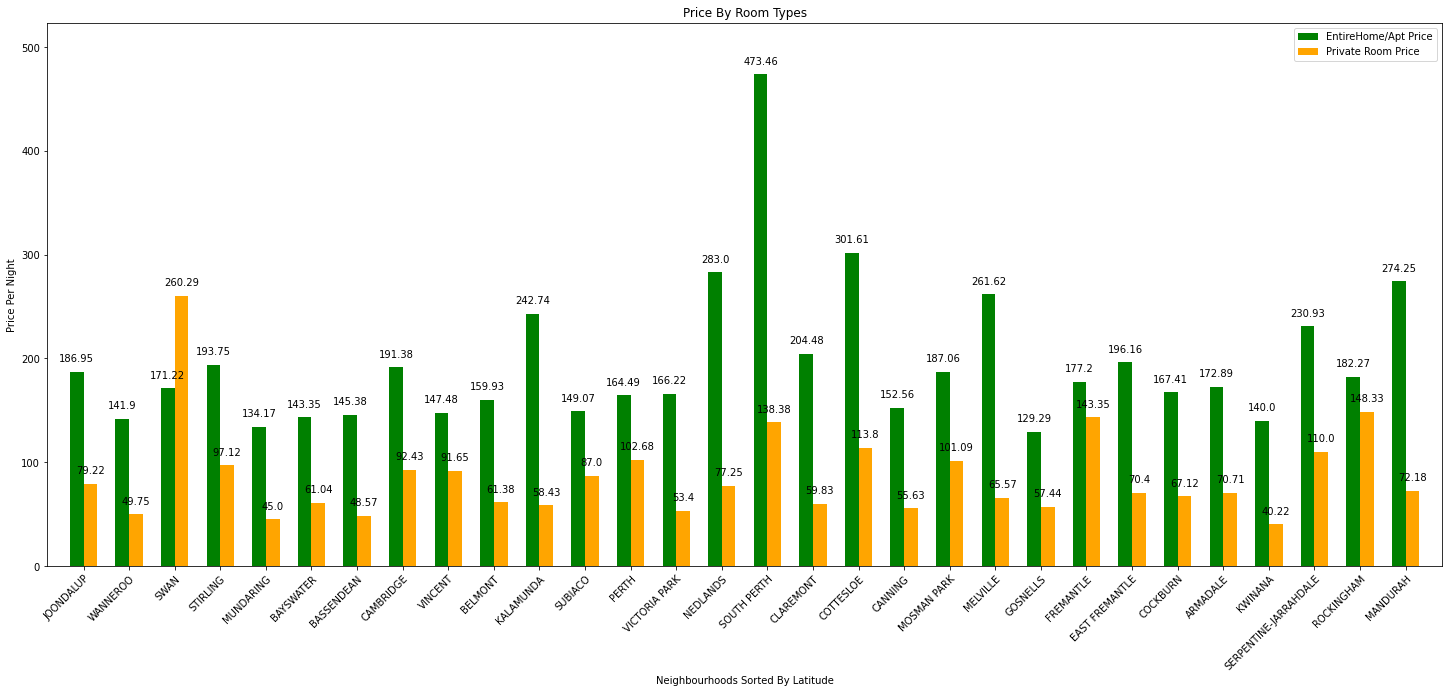

In [128]:
#Analyse The Relationship Between Neighbourhoods And Average Price Of Two Room Types

x_ticks=final_df['Neighbourhoods']
x_axis=np.arange(len(x_ticks))
xvalue=final_df['EntireHome/Apt Price']
x1value=final_df['Private Room Price']
plt.figure(figsize=(25, 10))
plt.bar(x_axis-0.15,xvalue,facecolor='green',align='center',width=0.3,)
plt.bar(x_axis+0.15,x1value,facecolor='orange',align='center',width=0.3)

for x,y in enumerate(final_df['EntireHome/Apt Price']):
    plt.text(x-0.15,y+10,'%s'%y,ha='center')
for x,y in enumerate(final_df['Private Room Price']):
    plt.text(x+0.15,y+10,'%s'%y,ha='center')


tick_locations = [value for value in x_axis]
labels=['EntireHome/Apt Price','Private Room Price']
plt.xticks(tick_locations,x_ticks,rotation_mode='anchor',ha='right',rotation=45)
plt.title('Price By Room Types')
plt.xlabel('Neighbourhoods Sorted By Latitude')
plt.ylabel('Price Per Night')
plt.xlim(-0.8,29.8)
plt.ylim(0,max(xvalue)+50)
plt.legend(labels);
plt.savefig('OutputData/result1.png',dpi=400)

## Visualize results

In [129]:
#Heatmaps To Show The Total Reviews By Suburbs

lat=[]
lng=[]
for city in final_df['Neighbourhoods']:
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={city},Australia&key={gkey}"
    geo_data = requests.get(target_url).json()
    lat.append(geo_data['results'][0]['geometry']['location']['lat'])
    lng.append(geo_data['results'][0]['geometry']['location']['lng'])
locations=list(zip(lat,lng))
fig=gmaps.figure(center=(-31.975,115.8333),zoom_level=10)


weights=final_df['Total Reviews']
heat_layer=gmaps.heatmap_layer(locations,weights=weights,max_intensity = 28000,point_radius = 50)
fig.add_layer(heat_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [130]:
#Heatmaps To Show The Average Price By Suburbs

fig=gmaps.figure(center=(-31.975,115.8333),zoom_level=11)
lat=[latitude for latitude in cleaned_df['latitude']]
lng=[longitude for longitude in cleaned_df['longitude']]
locations=list(zip(lat,lng))
weights=cleaned_df['price']
heat_layer=gmaps.heatmap_layer(locations,weights=weights,max_intensity = 500,point_radius = 5)
fig.add_layer(heat_layer)
fig


Figure(layout=FigureLayout(height='420px'))

## Correlation Test


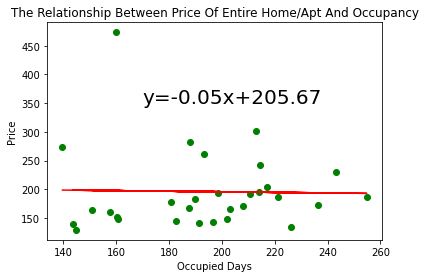

In [131]:
#Analyse The Correlation Between Pirce and Occupancy For Type Of Entire Home/Apt

x=final_df['EntireHome/Apt Occupancy']
y=final_df['EntireHome/Apt Price']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x,y)
regression_value=round(slope,2)*x+round(intercept,2)
function=f'y={round(slope,2)}x+{round(intercept,2)}'

plt.scatter(x,y,facecolor='green')
plt.plot(x,regression_value,color='red',linewidth=1.5)
plt.annotate(function,xy=(170,350),fontsize=20)
plt.title('The Relationship Between Price Of Entire Home/Apt And Occupancy')
plt.xlabel('Occupied Days')
plt.ylabel('Price')
plt.savefig('OutputData/result2.png',dpi=400)
plt;

In [132]:
#Show the Results

print(rvalue)

-0.022396921681552558


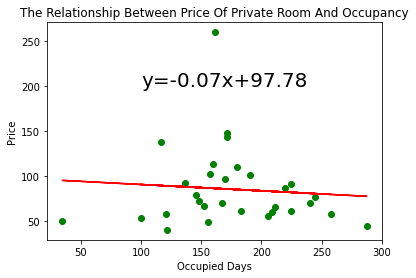

In [133]:
#Analyse The Correlation Between Pirce and Occupancy For Type Of Private Room

x=final_df['Private Room Occupancy']
y=final_df['Private Room Price']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x,y)
regression_value=round(slope,2)*x+round(intercept,2)
function=f'y={round(slope,2)}x+{round(intercept,2)}'


plt.scatter(x,y,facecolor='green')
plt.plot(x,regression_value,color='red',linewidth=1.5)
plt.annotate(function,xy=(100,200),fontsize=20)
plt.title('The Relationship Between Price Of Private Room And Occupancy')
plt.xlabel('Occupied Days')
plt.ylabel('Price')
plt.savefig('OutputData/result3.png',dpi=400)
plt;


In [134]:
#Show the Results

print(rvalue)

-0.0796307779044359


## Advertising A Metropolitan-Area Property On Airbnb


In [135]:
#Analyse Would Price Change If The Timeframe Change Based On Two Room Types 

entireHome_apt_df=df.loc[(df['latitude']>= -32.5468) &
                (df['latitude'] <= -31.7725) &
                (df['longitude'] <= 116.0593) &
                (df['room_type'] == 'Entire home/apt')]


privateRoom_df=df.loc[(df['latitude']>= -32.5468) &
               (df['latitude'] <= -31.7725) &
               (df['longitude'] <= 116.0593) &
               (df['room_type'] == 'Private room')]

entireHome_apt_df=entireHome_apt_df.copy()

privateRoom_df=privateRoom_df.copy()

In [136]:
entireHome_apt_df.head()

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,availability_365
0,13996997,SOUTH PERTH,-31.97013,115.85443,Entire home/apt,273,4,100,2022-05-28,200
1,52829205,STIRLING,-31.86853,115.75194,Entire home/apt,664,3,15,2022-05-27,316
2,47722611,PERTH,-31.95255,115.83302,Entire home/apt,299,2,35,2022-06-05,84
3,21872065,PERTH,-31.96113,115.86053,Entire home/apt,170,7,1,2018-05-28,58
4,731606,FREMANTLE,-32.04453,115.74471,Entire home/apt,100,4,197,2021-06-29,137


In [137]:
privateRoom_df.head()

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,availability_365
10,47817778,FREMANTLE,-32.03423,115.76062,Private room,528,1,8,2022-06-05,357
11,6331788,PERTH,-31.94852,115.88150,Private room,80,1,0,NaN,363
14,2115,SOUTH PERTH,-32.00871,115.86407,Private room,140,1,72,2022-01-23,108
15,37688,MELVILLE,-32.06806,115.87674,Private room,71,1,0,NaN,365
17,59311,GOSNELLS,-32.07592,115.93188,Private room,65,1,7,2018-04-28,362


In [138]:
#ASegregating Based On Number Of Stay Periods
#Holiday: 20 days
#Short Term: 20 to 60 days
#Medium Term: 60 to 90
#Long Term: >90 days
bins = [0,20,60,90,1000]
group_names = ["Holiday","short term","Medium term","Long Term"]

In [139]:
# For Entire Home/Apt

entireHome_apt_df["Stay classification"] =pd.cut(entireHome_apt_df["minimum_nights"], bins, labels=group_names)

#Group Neighbourhood And Stay Classification To Uncover The Price Change

avg_price_entire_apt = round((entireHome_apt_df.groupby(['neighbourhood','Stay classification'])["price"].mean()),2)

#Output The Result

avg_price_entire_apt.to_csv('OutputData/avgprice_entireHome_apt_.csv', encoding='utf-8') 

avg_price_entire_apt       

neighbourhood  Stay classification
ARMADALE       Holiday                163.10
               short term             160.00
               Medium term               NaN
               Long Term                 NaN
BASSENDEAN     Holiday                145.38
                                       ...  
VINCENT        Long Term               74.67
WANNEROO       Holiday                159.00
               short term                NaN
               Medium term               NaN
               Long Term               47.00
Name: price, Length: 128, dtype: float64

In [140]:
# For Private Room

privateRoom_df["Stay classification"] = pd.cut(privateRoom_df["minimum_nights"], bins, labels=group_names, include_lowest=True)

#Group Neighbourhood And Stay Classification To Uncover The Price Change

avg_price_private_room = round(privateRoom_df.groupby(['neighbourhood','Stay classification'])["price"].mean(),2)

#Output The Result

avg_price_private_room.to_csv('OutputData/avgprice_privateRoom.csv', encoding='utf-8')  

avg_price_private_room


neighbourhood  Stay classification
ARMADALE       Holiday                 82.32
               short term              42.00
               Medium term               NaN
               Long Term                 NaN
BASSENDEAN     Holiday                 63.33
                                       ...  
VINCENT        Long Term                 NaN
WANNEROO       Holiday                116.45
               short term                NaN
               Medium term               NaN
               Long Term                 NaN
Name: price, Length: 120, dtype: float64

## Trends of Price 

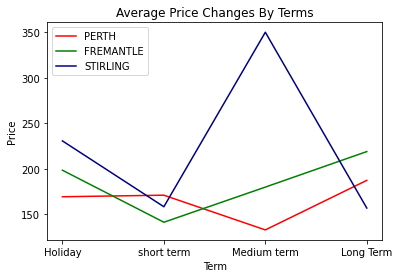

In [141]:
#average price between short, medium and long-term stays about Entire Home/Apt

ResetIndex=avg_price_entire_apt.reset_index()
PERTH=ResetIndex.loc[ResetIndex['neighbourhood']=='PERTH']
FREMANTLE=ResetIndex.loc[ResetIndex['neighbourhood']=='FREMANTLE']
STIRLING=ResetIndex.loc[ResetIndex['neighbourhood']=='STIRLING']
label=['PERTH','FREMANTLE','STIRLING']

plt.plot(PERTH['Stay classification'],PERTH['price'],color='red')
plt.plot(FREMANTLE['Stay classification'],FREMANTLE['price'],color='green')
plt.plot(STIRLING['Stay classification'],STIRLING['price'],color='navy')
plt.title('Average Price Changes By Terms')
plt.xlabel('Term')
plt.ylabel('Price')
plt.legend(label);
plt.savefig('OutputData/result4.png',dpi=400)